In [1]:
%load_ext autoreload
%autoreload 2

import exifread
import matplotlib.pyplot as plt
import numpy as np
from PIL import ExifTags, Image

from dhdrnet.gen_pairs import GenAllPairs
from dhdrnet.util import ROOT_DIR

%matplotlib inline

FIGDIR = ROOT_DIR / "figures"
DATA_DIR = ROOT_DIR / "data"

In [3]:
from more_itertools import sample

dng_sample = sample((DATA_DIR / "dngs").iterdir(), k=1)[0]

f = dng_sample.open("rb")
tags = exifread.process_file(f, details=False)
print(dng_sample)
tags

/home/shane/src/DHDRNet/data/dngs/0030_20151215_114255_355.dng


{'Image SubfileType': (0x00FE) Long=Reduced-resolution image @ 18,
 'Image ImageWidth': (0x0100) Long=640 @ 30,
 'Image ImageLength': (0x0101) Long=480 @ 42,
 'Image BitsPerSample': (0x0102) Short=[8, 8, 8] @ 530,
 'Image Compression': (0x0103) Short=JPEG @ 66,
 'Image PhotometricInterpretation': (0x0106) Short=6 @ 78,
 'Image Make': (0x010F) ASCII=Huawei @ 536,
 'Image Model': (0x0110) ASCII=Nexus 6P @ 544,
 'Image StripOffsets': (0x0111) Long=20946 @ 114,
 'Image Orientation': (0x0112) Short=Horizontal (normal) @ 126,
 'Image SamplesPerPixel': (0x0115) Short=3 @ 138,
 'Image RowsPerStrip': (0x0116) Long=480 @ 150,
 'Image StripByteCounts': (0x0117) Long=218505 @ 162,
 'Image PlanarConfiguration': (0x011C) Short=1 @ 174,
 'Image Software': (0x0131) ASCII=HDR+ 1.0.109032648r [SlowRaw] [burst_process] @ 554,
 'Image DateTime': (0x0132) ASCII=2017:11:02 16:33:33 @ 600,
 'Image Tag 0x014A': (0x014A) Long=1174 @ 210,
 'Image YCbCrCoefficients': (0x0211) Ratio=[299/1000, 587/1000, 57/500] @

In [5]:
print(tags["EXIF FNumber"].values[0])
print(tags["EXIF ShutterSpeedValue"].values[0].num)

2
10727071


In [6]:
tags["EXIF ShutterSpeedValue"].values[0].num / tags["EXIF ShutterSpeedValue"].values[
    0
].den

10.727071

In [7]:
def exif(p):
    f = p.open("rb")
    tags = exifread.process_file(f, details=True)
    fn = tags["EXIF FNumber"].values[0].num
    shutter_speed = (
        tags["EXIF ShutterSpeedValue"].values[0].num
        / tags["EXIF ShutterSpeedValue"].values[0].den
    )

    return np.log2((fn ** 2) / (shutter_speed))

In [8]:
from dhdrnet.gen_pairs import ev_from_exif

In [9]:
ev_from_exif(dng_sample)

-1.4231843004669438

In [10]:
exif(dng_sample)

-1.4231843004669436

In [11]:
import time

t = time.process_time()
for s in sample((DATA_DIR / "dngs").iterdir(), k=100):
    exif(s)
elapsed = time.process_time() - t
print(f"average time for naive exif = {elapsed / 100}")

average time for naive exif = 0.0018231682000000005


In [12]:
t = time.process_time()
for s in sample((DATA_DIR / "dngs").iterdir(), k=100):
    ev_from_exif(s)
elapsed = time.process_time() - t
print(f"average time for smarter? exif = {elapsed / 100}")

average time for smarter? exif = 0.0018062823900000025


In [20]:
all_evs = {d.stem: ev_from_exif(d) for d in (DATA_DIR / "dngs").iterdir()} #if "synth" not in d.stem}
len(all_evs)

3640

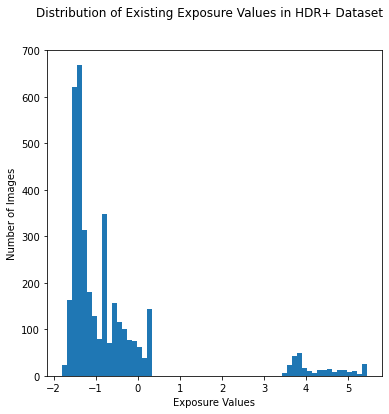

In [22]:
fig = plt.figure(figsize=(6, 6))
plt.tight_layout()
plt.hist(all_evs.values(), bins="auto")
plt.suptitle("Distribution of Existing Exposure Values in HDR+ Dataset")
plt.xlabel("Exposure Values")
plt.ylabel("Number of Images")
fig.savefig(FIGDIR / "BaseEVDist.pdf")

get a bunch of low ev images

In [23]:
low_evs = {k: v for k, v in all_evs.items() if v < -1}
low_sample = sample(low_evs.items(), k=15)
im_sample = sample(all_evs.items(), k=10)

In [14]:
import datetime

gen = GenAllPairs(raw_path=DATA_DIR / "dngs", out_path=DATA_DIR)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/shane/.cache/pypoetry/virtualenvs/dhdrnet-CxDQYEDG-py3.8/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


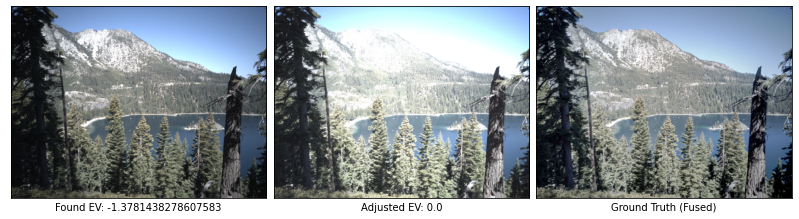

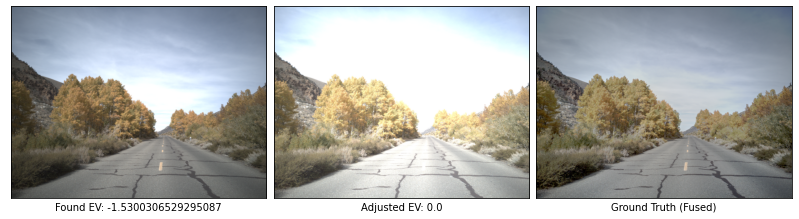

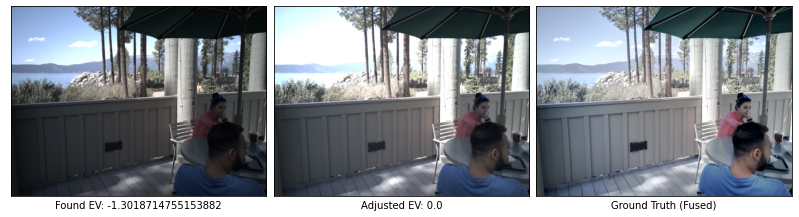

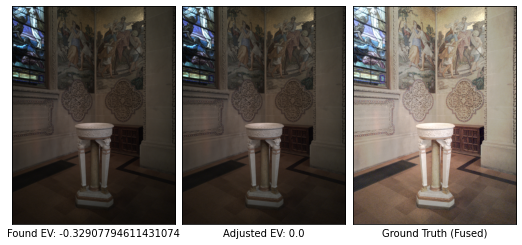

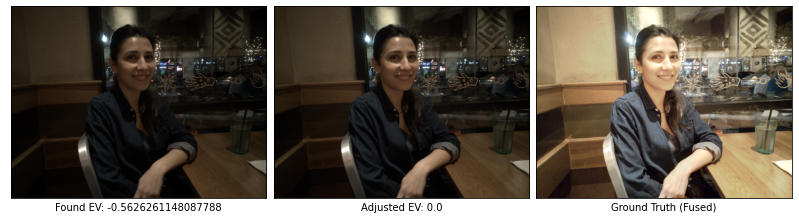

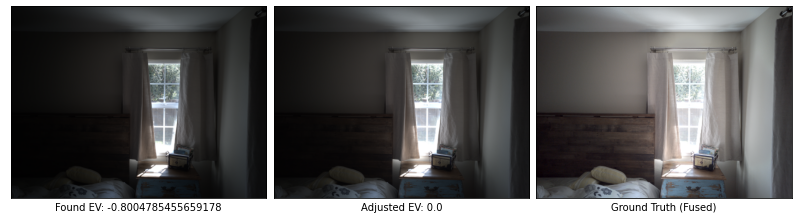

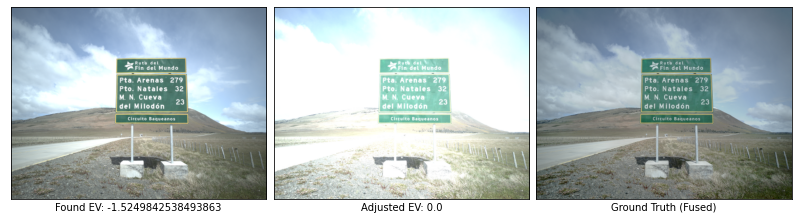

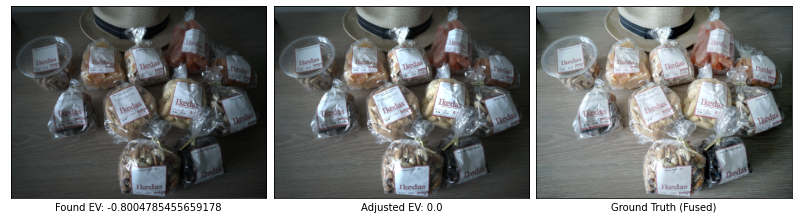

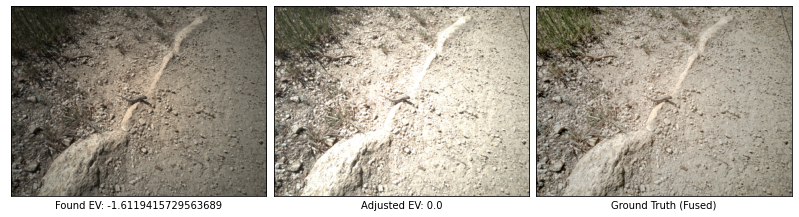

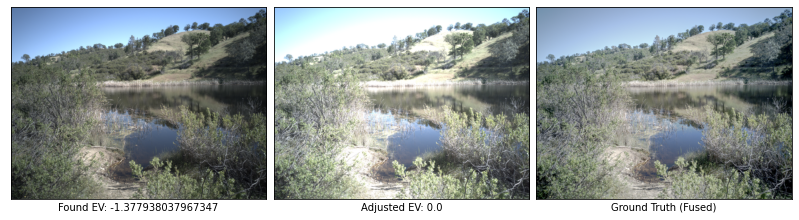

In [15]:
from itertools import cycle

from mpl_toolkits.axes_grid1 import ImageGrid

for ip, ev in im_sample:
    gt = gen.get_ground_truth(ip)
    fig = plt.figure(figsize=(14, 4))
    plt.tight_layout()
    imgbase, img_ev0 = gen.get_exposures(ip, [0, -ev])
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)
    for ax, im, cev in zip(
        grid,
        [imgbase, img_ev0, gt],
        cycle([f"Found EV: {ev}", "Adjusted EV: 0.0", "Ground Truth (Fused)"]),
    ):
        ax.imshow(im[..., [2, 1, 0]])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(cev)
    #     fig.suptitle(f"{ip} EV: {ev}")
    fig.savefig(
        FIGDIR / "ev_comparisons" / f"{ip}_ev_comparison.png",
        bbox_inches="tight",
        transparent="True",
        pad_inches=0,
    )